In [1]:
import numpy as np
import csv
import cv2
import random
import matplotlib.pylab as plt
%matplotlib inline
from data_adaptation import *

## Final Model

After trying what is described in [behavioral cloning](./Behavioral Cloning.ipnb), I tried to use what other students had been successful with and it was recommended by my mentor. I  tried to train both commaai model and nvidia. The car drove a little better but I still had many problems training it to go around the course. For that reason, I went back to basics.

By reading around I found that other people had been successful in training this models with far fewer samples that I have. In fact, by this time I was training the network on more that 100k samples depending on what filtering of the distribution I was doing. Therefore, I decided to check how well my model could represent the data. For that I was a lot more aggressive with cropping the image, and I added a resizing step that makes it a lot smaller.

The first step is reading the data to check its distribution.

### Data Distribution

In [2]:
data_folder = '../CarND-Data-P3/data_final/'
read_lines = []
bins = 200
samples_per_bin = 500

with open(data_folder + 'driving_log.csv') as csv_file:
    reader = csv.reader(csv_file)
    for line in reader:
        read_lines.append(line)
lines = np.array(read_lines[1:])

In [3]:
print('Total data lines from driving data: ', len(lines))
print('That makes a total data points after augmentation: ', 6 * len(lines))

Total data lines from driving data:  21153
That makes a total data points after augmentation:  126918


In [4]:
angles_list = []
for line in lines:
    angles_list.append(float(line[3].strip()))
angles = np.array(angles_list)

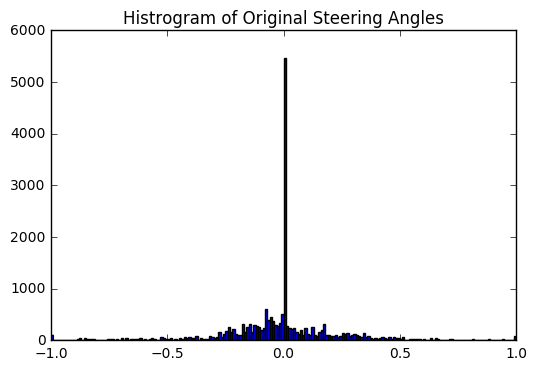

In [6]:
hist_original = plt.hist(angles, bins = bins)
title = plt.title('Histrogram of Original Steering Angles')

Even with all the new data compiled, which is mainly of curves and includes data from the challenge track, the distribution is still quite bias towards driving straight. What I did was limit the amount of samples that are selected for each bucket of the histogram. By setting that value, I can put a cap on how many samples are taken with 0 or close to 0 steering angle. 

In [7]:
used_samples = []
# make use extremes are included
hist_original[1][-1] += 0.0000001
bin_start = min(angles)
for bin_end in hist_original[1][1:]:
    selectable = np.where(np.logical_and(angles >= bin_start, angles < bin_end))
    samples_in_bin = len(angles[selectable])
    if samples_in_bin > samples_per_bin:
        idx = np.random.choice(samples_in_bin, samples_per_bin, replace=False)
        select_from = lines[selectable]
        used_samples.append(select_from[idx])
    else:
        used_samples.append((lines[selectable]))
    bin_start = bin_end
used_samples = np.concatenate(used_samples)

In [8]:
angles_list = []
for line in used_samples:
    angles_list.append(float(line[3].strip()))
used_angles = np.array(angles_list)

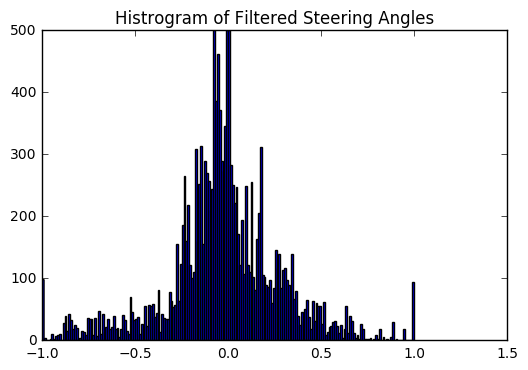

In [9]:
hist_mod = plt.hist(used_angles, bins = hist_original[1])
title = plt.title('Histrogram of Filtered Steering Angles')

In [17]:
print('Lines available after selection:', len(used_samples))
print('Samples available after selection:', len(used_samples) * 6)

Lines available after selection: 16060
Samples available after selection: 96360


Now, the samples to take for training look a lot closer to a normal distribution which should make it easier to train. After this filtering we still have 16060 data points. Taking into consideration data augmentation (left and right images plus mirroring) we still have 96360 samples to train with.

### Model

The first step would be to train it with a very limited set of data. That way, I can check if it can over-fit the data. This is an indication that it has sufficient expressive power. I felt the need to take that step because I reduced quite a bit the amount of information that I was passing to the model. After preprocesing, I passing a 64x32 pixel image to it. Let’s see how that data looks like.

#### Original Samples

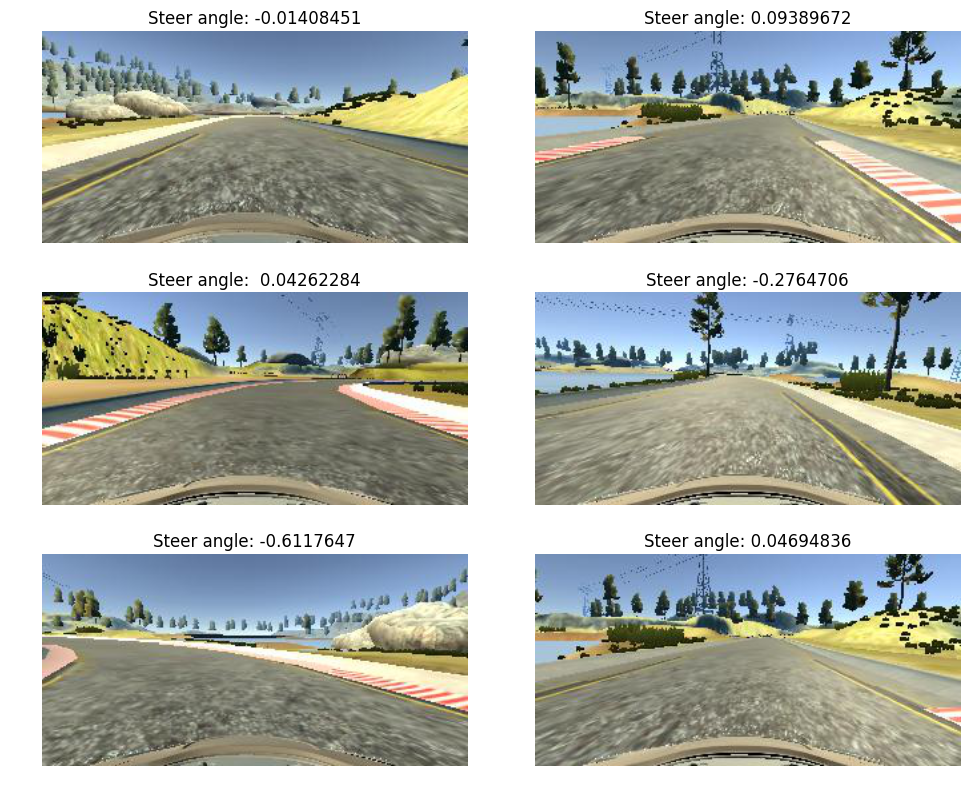

In [17]:
# select a few samples to work with
# list of samples for reference
example_lines = []
n = 3
m = 2
fig, ax = plt.subplots(n, m)
for a, sample in zip(ax.flatten(),range(n * m)):
    selected_test = np.random.randint(0, len(used_samples))
    line = used_samples[selected_test]
    example_lines.append(line)
    img = cv2.imread(data_folder + line[0].strip())
    a.imshow(toRGB(img))
    a.set_title('Steer angle: ' + line[3])
    a.axis('off')
fig.set_size_inches(10,8)
fig.tight_layout()

#### Proccessed Samples

In [101]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU
from keras.layers.convolutional import Convolution2D, Cropping2D
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2

Using TensorFlow backend.


In [102]:
model = Sequential()
model.add(Cropping2D(cropping=((55, 20), (0, 0)), input_shape=(160, 320, 3)))
model.add(Lambda(lambda x: x/127.5 - 1., ))
model.add(Convolution2D(16, (8, 8), strides=(4, 4), padding="same", input_shape=(160, 320, 3)))
model.add(ELU())
model.add(Convolution2D(32, (5, 5), strides=(2, 2), padding="same"))
model.add(ELU())
model.add(Convolution2D(64, (5, 5), strides=(2, 2), padding="same"))
model.add(Flatten())
# I'm taking out mechanism to avoid overfitting, this time, overfit.
#model.add(Dropout(.2))
model.add(ELU())
#model.add(Dense(512, kernel_initializer='glorot_normal', kernel_regularizer=l2(0.001)))
model.add(Dense(512, kernel_initializer='glorot_normal'))
#model.add(Dropout(.5))
model.add(ELU())
model.add(Dense(1))

model.compile(optimizer="adam", loss="mse")
#model.fit(X_train, y_train, batch_size=32, validation_split=0.3, shuffle=True, epochs=50, callbacks=[saving])

In [103]:
np.random.shuffle(used_samples)
val_lines = max(1 ,int(len(used_samples) * 0.3))
validation = used_samples[:val_lines]
training = used_samples[int(len(used_samples) * 0.3):]
print('Size of training set lines:', len(training))
print('size of validation set lines:', len(validation))

Size of training set lines: 234
size of validation set lines: 100


In [104]:
print('Size of training set frames:', len(training) * 6)
print('size of validation set frames:', len(validation))
batch_size = min(2048, len(training) * 6)
train_gen = generate_train_data(training, data_folder, batch_size) # minimum batch size is 1 line, equivalently 6 samples
val_gen = generate_val_data(validation, data_folder)

Size of training set frames: 1404
size of validation set frames: 100


In [33]:
X_train, y_train = get_training_data(used_samples, data_folder)
model.fit(X_train, y_train, batch_size=32, validation_split=0.3, shuffle=True, epochs=100, verbose=1)

NameError: name 'model' is not defined

In [ ]:
n = 3
m = 2
fig, ax = plt.subplots(n, m)
for a, sample, angle in zip(ax.flatten(), X_train, y_train):
    #img = cv2.imread(data_folder + sample[0].strip())
    # Crop images to see what the classifiers sees
    #a.imshow(toRGB(img[:, :, :]))
    a.imshow(sample)
    steer_estimate = model.predict(sample[None,:,:,:], batch_size=1)[0][0]
    a.set_title('Steer angle: ' + str(angle) + '\n' + 'Estimated angle: ' + str(steer_estimate) + '\n' +
                'error: ' + str(abs(angle - steer_estimate)))
fig.set_size_inches(10,8)
fig.tight_layout()

In [ ]:
np.random.randint(0,6)

In [ ]:
total_samples = len(training) * 6
steps_epoch = total_samples // batch_size  # uncomment this to loop through all samples in selected samples
print('Proccesing', batch_size, 'frames on each batch')
print('Proccesing ', steps_epoch, 'batches on each epoch')
model.fit_generator(generator=train_gen, steps_per_epoch=steps_epoch, validation_data=val_gen,
                    validation_steps=len(validation), epochs=100, verbose=1)
model.save('commaai_overfit')

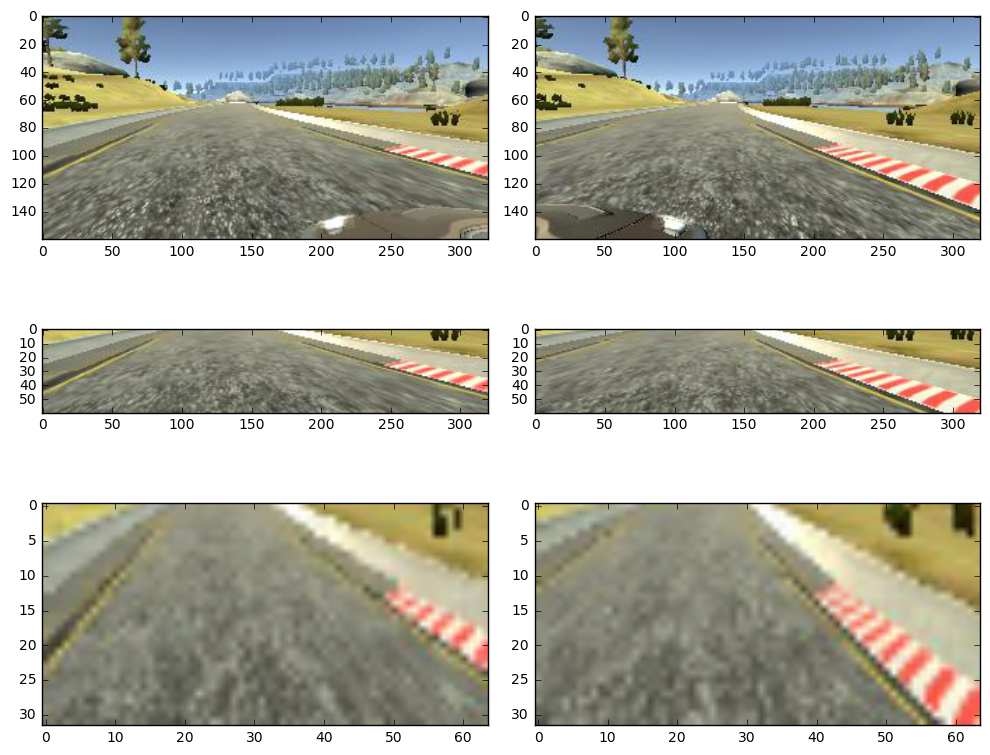

In [137]:
n = 85
fig, ax = plt.subplots(3, 2)
sample1 = training[n][1].strip()
sample2 = training[n][2].strip()
img1 = toRGB(cv2.imread(sample1))
img2 = toRGB(cv2.imread(sample2))
crop1 = img1[70:130, :]
crop2 = img2[70:130, :]
res1 = cv2.resize(crop1, (64,32))
res2 = cv2.resize(crop2, (64,32))
ax[0][0].imshow(img1)
ax[1][0].imshow(crop1)
ax[2][0].imshow(res1)
ax[0][1].imshow(img2)
ax[1][1].imshow(crop2)
ax[2][1].imshow(res2)
fig.set_size_inches(10,8)
fig.tight_layout()

TypeError: 'NoneType' object is not subscriptable

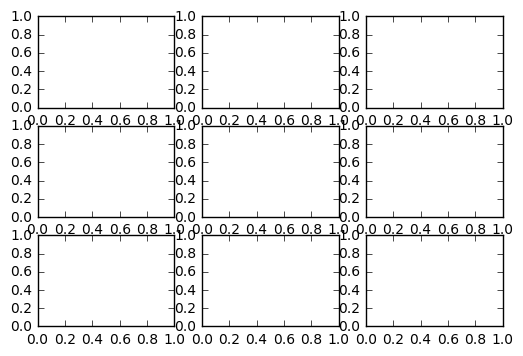

In [120]:
n = 3
m = 3
fig, ax = plt.subplots(n, m)
for a, sample in zip(ax.flatten(), training):
    img = cv2.imread(data_folder + sample[0].strip())
    # Crop images to see what the classifiers sees
    a.imshow(toRGB(img[:, :, :]))
    steer_estimate = 0
    a.set_title('Steer angle: ' + sample[3] + '\n' + 'Estimated angle: ' + str(steer_estimate) + '\n' +
                'error: ' + str(abs(float(sample[3]) - steer_estimate)))
fig.set_size_inches(10,8)
fig.tight_layout()